In [1]:
import cv2
import random
import json
import time

import torch
import numpy as np
from tqdm import tqdm

import clip
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from segment_anything.utils.transforms import ResizeLongestSide 

from PIL import Image  
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image

from sam_caf import hyper_params_tuning, get_crops, retrieve_relevant_crop, retrieve_relevant_crop_cpu_biomed, get_sam_prompts, sam_predicton

In [2]:
#config
class DictToObject:
    def __init__(self, dict_obj):
        for key, value in dict_obj.items():
            setattr(self, key, value)

config_dict = {
    "model_name" : "SAM",
    "model_type" : "vit_h",
    "source":    "False", 
    "refine" : "False",
    "pre_trained": "True", 
    "sam_ckpt":  "/data/aofei/LLM/SAM/sam_vit_h_4b8939.pth", 
    "clip_prompts": "./clip_prompts/abd_seg.json"
}

config = DictToObject(config_dict)

prompt_mode, mode = "crops", "sam_clip"

In [3]:
clip_model, preprocess = clip.load("ViT-L/14", device="cuda")
sam_checkpoint = config.sam_ckpt

sam = sam_model_registry[config.model_type](checkpoint=sam_checkpoint)
sam.to("cuda")
resize_transform = ResizeLongestSide(sam.image_encoder.img_size)

# ----- CLIP Prompts -----

with open(config.clip_prompts, "r") as file:
    prompts = json.load(file)

dice_scores = []
mask_generator, area = hyper_params_tuning(sam)

In [4]:
prompts

{'liver': ['Normal liver with smooth margins and homogeneous texture',
  'Heterogeneous liver texture with focal lesions']}

In [5]:
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (256, 256))
    return image

In [6]:
example_image1 = "./samples/example1.jpg"
image = preprocess_image(image_path=example_image1)
with torch.no_grad():
    # if mode == "sam_clip":
    masks = mask_generator.generate(image)
    masks = [mask for mask in masks if mask["area"] < area] # area filtering based on area value from hyper-params tuning

    img_crops = get_crops(image, masks, prompt_mode)
    max_indices, scores = retrieve_relevant_crop(img_crops, prompts, clip_model, preprocess, config)
    
        # ------  bbox cordinates relevant to crop ------
    for k in max_indices:
        max_indices[k] = [max_indices[k]]
    bboxes, relevant_crop, img_with_bboxes = get_sam_prompts(image, masks, max_indices, img_crops)
    
    preds = sam_predicton(sam, image, resize_transform, bboxes, config, mode)

In [7]:
max_indices

{'liver': [13]}

In [8]:
# masks[4]

In [68]:
masks_original = masks.copy()
masks_filtered = []
for m in masks_original:
    x, y, w, h = m['bbox']
    if w >= 150:
        continue
    masks_filtered.append(m)
len(masks_filtered)
img_crops_filtered = get_crops(image, masks_filtered, prompt_mode)

### Viusalization

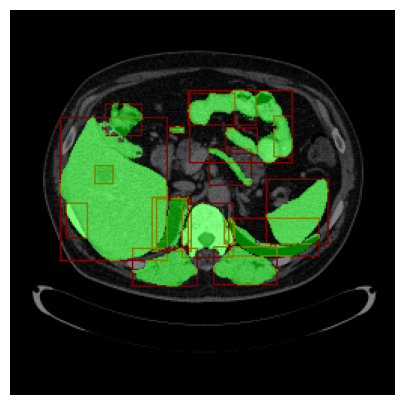

In [98]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image = cv2.imread("./samples/example1.jpg")
image = cv2.resize(image, (256, 256))
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def visualize_with_indices(masks, original_image, indices:tuple, width_threshold=180, fig_width=10):
    image_with_boxes = original_image.copy()

    # Create an empty mask with the same size as the image
    combined_mask = np.zeros_like(image_rgb, dtype=np.uint8)

    # Loop over all segmentation results
    for seg in masks[indices[0]:indices[1]]:
        # Unpack bbox (bounding box)
        x, y, w, h = seg['bbox']
        if w >= width_threshold:
            continue

        # Draw the bounding box (in red)
        cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), (255, 0, 0), 1)

        # Extract and resize the segmentation mask
        mask = seg['segmentation'].astype(np.uint8)
        mask = cv2.resize(mask, (image_rgb.shape[1], image_rgb.shape[0]))  # Resize to fit the image

        # Add mask to combined mask (use a different color for each mask if desired)
        color_mask = np.zeros_like(image_rgb)
        color_mask[mask == 1] = [0, 255, 0]  # Green mask for the segment
        combined_mask = np.maximum(combined_mask, color_mask)

    # Blend the original image with the combined mask once
    alpha = 0.5  # Transparency factor
    image_with_masks = cv2.addWeighted(image_with_boxes, 1 - alpha, combined_mask, alpha, 0)

    # Display the image with bounding boxes and masks
    plt.figure(figsize=(fig_width, fig_width))
    plt.imshow(image_with_masks)
    plt.axis('off')  # Turn off axis for clean visualization
    plt.show()

visualize_with_indices(masks_filtered, image_rgb, (0, -1), fig_width=5)

In [87]:
# visualize_with_indices((12, 13))
get_topk_similar(5, scores["liver"])

[(10, 22.203125), (5, 21.0625), (13, 20.6875), (15, 20.6875), (0, 20.40625)]

In [88]:
prompts2 = {"cancer": ["lesion on the liver"]}
prompt_liver = {"liver": ["The liver appears as a large, homogenous, wedge-shaped organ."]}
prompt_liver2 = {"liver": ["liver."]}
max_indices, scores = retrieve_relevant_crop(img_crops_filtered, prompt_liver2, clip_model, preprocess, config)

In [89]:
get_topk_similar(5, scores["liver"])

[(5, 19.921875), (10, 19.0625), (13, 18.5625), (6, 17.921875), (0, 17.90625)]

### Load BioMedCLIP

In [8]:
import os
# os.environ["TRANSFORMERS_CACHE"]="/data/aofei/huggingface_cache/transformers"
os.environ["HF_HOME"]="/data/aofei/huggingface_cache/transformers"
from open_clip import create_model_from_pretrained, get_tokenizer # works on open-clip-torch>=2.23.0, timm>=0.9.8

biomed_clip_model, biomed_preprocess = create_model_from_pretrained('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224', device="cuda")
tokenizer = get_tokenizer('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')

/data/aofei/conda/env/medh/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/data/aofei/conda/env/medh/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/data/aofei/conda/env/medh/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/data/aofei/conda/env/medh/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.

In [20]:
# img_crops[0]
# a = tokenizer(["lesion on the liver in this abdominal CT"])
# b = biomed_clip_model.encode_text(a)
# b

In [91]:
prompts2 = {"cancer": ["Metastases may appear in a multitude of ways on CT scans. The majority of liver metastases are hypovascular (hypoattenuating) in comparison to surrounding parenchyma; therefore, on nonenhanced CT scans, most lesions appear either hypoattenuating or isoattenuating relative to the surrounding parenchyma."]}
prompt_liver = {"liver": ["The liver appears as a large, homogenous, wedge-shaped organ."]}
prompt_liver2 = {"liver": ["liver."]}
max_indices2, scores2 = retrieve_relevant_crop_cpu_biomed(img_crops_filtered, prompts2, biomed_clip_model, biomed_preprocess, config, tokenizer=tokenizer)

max_indices, scores = retrieve_relevant_crop_cpu_biomed(img_crops_filtered, prompt_liver2, biomed_clip_model, biomed_preprocess, config, tokenizer=tokenizer)

In [76]:
def get_topk_similar(k, crop_scores):
    sorted_scores = sorted([(i, m) for (i,m) in enumerate(crop_scores)], key=lambda x: x[1], reverse=True)
    return sorted_scores[:k]
get_topk_similar(5, scores["liver"])

[(10, 32.944950103759766),
 (16, 31.565481185913086),
 (13, 28.82687759399414),
 (2, 28.704788208007812),
 (14, 27.616811752319336)]

In [92]:
get_topk_similar(5, scores["liver"])

[(10, 33.039730072021484),
 (16, 27.883052825927734),
 (4, 27.83660888671875),
 (13, 27.805011749267578),
 (2, 25.330739974975586)]

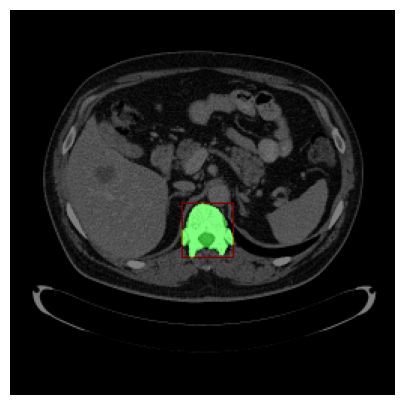

In [121]:
visualize_with_indices(masks_filtered, image_rgb, (4,5), width_threshold=250, fig_width=5)

### Example 2

In [95]:
example_image2 = "./samples/example2.jpg"
image2 = preprocess_image(image_path=example_image2)
with torch.no_grad():
    # if mode == "sam_clip":
    masks_e2 = mask_generator.generate(image2)
    masks_e2 = [mask for mask in masks_e2 if mask["area"] < area] # area filtering based on area value from hyper-params tuning

    img_crops_e2 = get_crops(image2, masks_e2, prompt_mode)

masks2_original = masks_e2.copy()
masks2_filtered = []
for m in masks2_original:
    x, y, w, h = m['bbox']
    if w >= 150:
        continue
    masks2_filtered.append(m)
len(masks2_filtered)
img_crops_filtered2 = get_crops(image2, masks2_filtered, prompt_mode)

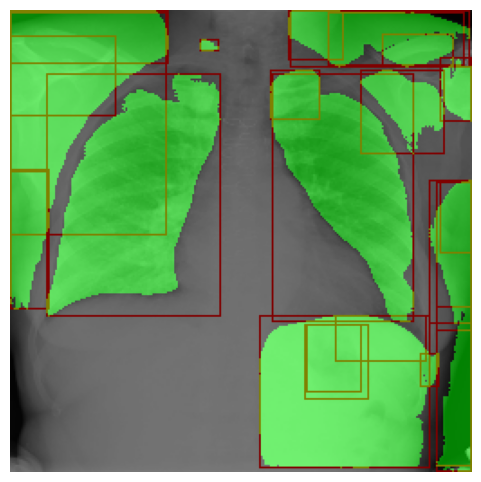

In [100]:
image = cv2.imread("./samples/example2.jpg")
image = cv2.resize(image, (256, 256))
image_rgb2 = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

visualize_with_indices(masks2_filtered,image_rgb2, (0, -1), fig_width=6)

In [96]:
len(masks2_filtered)

26

In [101]:
prompt_lung1 = {"lungs": ["The lungs."]}
max_indices_lung, scores_lung = retrieve_relevant_crop_cpu_biomed(img_crops_filtered2, prompt_lung1, biomed_clip_model, biomed_preprocess, config, tokenizer=tokenizer)

In [103]:
get_topk_similar(5, scores_lung["lungs"])

[(14, 31.944881439208984),
 (13, 28.589279174804688),
 (25, 27.086990356445312),
 (21, 26.501264572143555),
 (6, 25.243274688720703)]

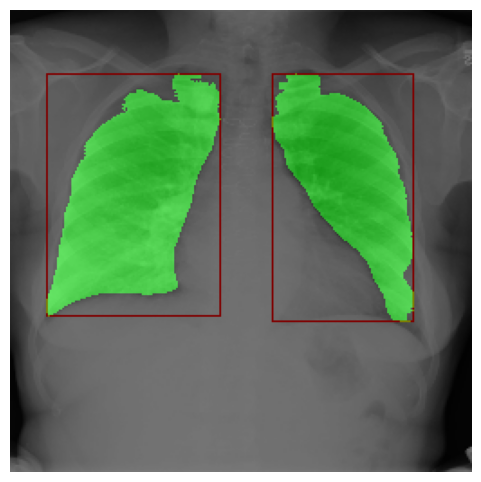

In [104]:
visualize_with_indices(masks2_filtered,image_rgb2, (13, 15), fig_width=6)